In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import os

In [2]:
# For using Google Colab only
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


base_path = '/content/drive/MyDrive/Data'

# Trade data
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Australia.xlsx'
trade_australia = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_Canada.xlsx'
trade_canada = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_China.xlsx'
trade_china = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_Kingdom.xlsx'
trade_uk = pd.read_excel(trade_path, skiprows=4, header=[0, 1])
trade_path = base_path + '/Data2/Export and Export to world/Trade_between_United_Arab_Emirates_and_United_States_of_America.xlsx'
trade_usa = pd.read_excel(trade_path, skiprows=4, header=[0, 1])

# Economic indicators
changing_scenarios = pd.read_excel('/content/drive/MyDrive/Data/Copy of changing scenerio.xlsx')


# Specify the folder path for economic data (only once)
economic_path = '/content/drive/MyDrive/Data/Data2/GDP etc/'

# Read the 'Expense.xlsx' file
expense = pd.read_excel(economic_path + 'Expense.xlsx', skiprows=4, header=[0, 1])
gdp_growth = pd.read_excel(economic_path + 'GDP growth.xlsx', skiprows=4, header=[0, 1])
inflation = pd.read_excel(economic_path + 'Inflation.xlsx', skiprows=4, header=[0, 1])
net_investment = pd.read_excel(economic_path + 'Net investment.xlsx', skiprows=4, header=[0, 1])

# Specify the folder path for import trade data (only once)
import_path = '/content/drive/MyDrive/Data/Data2/Import and Import from world/'

# Read the 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx' file
import_trade_canada = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Canada.xlsx', skiprows=4, header=[0, 1])
import_trade_china = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_China.xlsx', skiprows=4, header=[0, 1])
import_trade_india = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_India.xlsx', skiprows=4, header=[0, 1])
import_trade_uk = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_Kingdom.xlsx', skiprows=4, header=[0, 1])
import_trade_usa = pd.read_excel(import_path + 'Import Trade_between_United_Arab_Emirates_and_Unites_State_of_America.xlsx', skiprows=4, header=[0, 1])

In [4]:
trade_usa.head()

Product code                                      Product label  \
  Unnamed: 0_level_1                                 Unnamed: 1_level_1   
0             'TOTAL                                       All products   
1                '01                                       Live animals   
2                '02                         Meat and edible meat offal   
3                '03  Fish and crustaceans, molluscs and other aquat...   
4                '04  Dairy produce; birds' eggs; natural honey; edi...   

  United Arab Emirates's exports to United States of America                \
                                               Value in 2003 Value in 2004   
0                                                NaN                   NaN   
1                                                NaN                   NaN   
2                                                NaN                   NaN   
3                                                NaN                   NaN   
4                                                NaN                   NaN   

                                                                         \
  Value in 2005 Value in 2006 Value in 2007 Value in 2008 Value in 2009   
0        796518           NaN        699712       1230163           NaN   
1           246           NaN            20            27           NaN   
2            52           NaN           122            62           NaN   
3         20507           NaN         11214          4646           NaN   
4           379           NaN           134           267           NaN   

                 ... United Arab Emirates's exports to world                \
  Value in 2010  ...                           Value in 2013 Value in 2014   
0           NaN  ...                               371217682     343043070   
1           NaN  ...                                   59638        359214   
2           NaN  ...                                   81831         66076   
3           NaN  ...                                  128652        114418   
4           NaN  ...                                  374787        439388   

                                                                         \
  Value in 2015 Value in 2016 Value in 2017 Value in 2018 Value in 2019   
0     300478648     295046691     313547597     321006905     315942728   
1         57364         46087         42979         90455         56361   
2         49031         53463         70800        244690        652931   
3        114360        123412         76224        212978        190332   
4        642173        470889        539346        945655        988080   

                                             
  Value in 2020 Value in 2021 Value in 2022  
0     335296908     425159797     311313710  
1         42405         30095         23998  
2        258430        357568         28133  
3        140263        132971        234334  
4        881124        945101         84495  

[5 rows x 64 columns]

In [5]:
trade_usa.shape

(98, 64)

In [6]:
second_column = import_trade_usa.iloc[:, 1]  # Index 1 corresponds to the second column
print(second_column)

0                                          All products
1                                          Live animals
2                            Meat and edible meat offal
3     Fish and crustaceans, molluscs and other aquat...
4     Dairy produce; birds' eggs; natural honey; edi...
                            ...                        
93    Furniture; bedding, mattresses, mattress suppo...
94    Toys, games and sports requisites; parts and a...
95                  Miscellaneous manufactured articles
96        Works of art, collectors' pieces and antiques
97                  Commodities not elsewhere specified
Name: (Product label, Unnamed: 1_level_1), Length: 98, dtype: object


In [7]:
def clean_trade_data(df):
    # Drop rows with NaN values in the first 5 columns
    df = df.dropna(subset=df.columns[:5], how='all')

    # Rename columns
    df.columns = [' '.join(map(str, col)).strip() if 'Unnamed' not in col else str(col[0]) for col in df.columns.values]

    # Simplify column names
    new_columns = []
    for col in df.columns:
        if 'Value in' in col:
            new_columns.append(col.split()[-1])  # Just the year
        elif 'Product code' in col:
            new_columns.append('Product Code')
        elif 'Product label' in col:
            new_columns.append('Product Label')
        else:
            new_columns.append(col)  # The first part of the tuple
    df.columns = new_columns

    # Drop columns and rows that are completely NaN
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df


In [202]:
df=clean_trade_data(trade_canada)  # selecting desired import ,export country

In [203]:
df.head()

,Product Code,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,'TOTAL,All products,29478,46792,289622,123092,115754,108974,163044,171547,...,371217682,343043070,300478648,295046691,313547597,321006905,315942728,335296908,425159797,311313710
1,'01,Live animals,0,6,13,6,8,6,8,467,...,59638,359214,57364,46087,42979,90455,56361,42405,30095,23998
2,'02,Meat and edible meat offal,0,0,13,0,0,0,0,0,...,81831,66076,49031,53463,70800,244690,652931,258430,357568,28133
3,'03,"Fish and crustaceans, molluscs and other aquat...",783,379,212,100,61,28,421,38,...,128652,114418,114360,123412,76224,212978,190332,140263,132971,234334
4,'04,Dairy produce; birds' eggs; natural honey; edi...,2,117,65,46,54,307,107,172,...,374787,439388,642173,470889,539346,945655,988080,881124,945101,84495


In [204]:
# dropping product code column
df = df.drop(df.columns[0], axis=1)

In [205]:
df.head()

,Product Label,2005,2007,2008,2012,2013,2014,2015,2016,2017,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,All products,29478,46792,289622,123092,115754,108974,163044,171547,298571,...,371217682,343043070,300478648,295046691,313547597,321006905,315942728,335296908,425159797,311313710
1,Live animals,0,6,13,6,8,6,8,467,7,...,59638,359214,57364,46087,42979,90455,56361,42405,30095,23998
2,Meat and edible meat offal,0,0,13,0,0,0,0,0,0,...,81831,66076,49031,53463,70800,244690,652931,258430,357568,28133
3,"Fish and crustaceans, molluscs and other aquat...",783,379,212,100,61,28,421,38,112,...,128652,114418,114360,123412,76224,212978,190332,140263,132971,234334
4,Dairy produce; birds' eggs; natural honey; edi...,2,117,65,46,54,307,107,172,337,...,374787,439388,642173,470889,539346,945655,988080,881124,945101,84495


In [206]:
# selecting desired product by index
df=df.iloc[4]

In [207]:
df.head()

Product Label    Dairy produce; birds' eggs; natural honey; edi...
2005                                                             2
2007                                                           117
2008                                                            65
2012                                                            46
Name: 4, dtype: object

In [208]:
print(df)

Product Label    Dairy produce; birds' eggs; natural honey; edi...
2005                                                             2
2007                                                           117
2008                                                            65
2012                                                            46
2013                                                            54
2014                                                           307
2015                                                           107
2016                                                           172
2017                                                           337
2018                                                           334
2019                                                           148
2020                                                           568
2021                                                           437
2003                                                        34

In [209]:
# Remove the title rows without affecting the columns
df = df.iloc[4:]

In [210]:
df=pd.DataFrame(df)

In [211]:
df.head()

,4
2012,46
2013,54
2014,307
2015,107
2016,172


In [212]:
# selecting first 10 rows since after that data is for import or export to world
df = df.iloc[:10]

print(df)

        4
2012   46
2013   54
2014  307
2015  107
2016  172
2017  337
2018  334
2019  148
2020  568
2021  437


<Axes: >

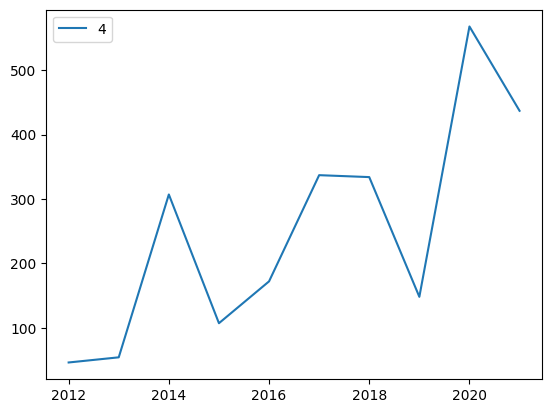

In [213]:
df.plot()

In [214]:

# Convert the years column to a datetime index and set the column name as 'Date'
df.index = pd.to_datetime(df.index, format='%Y')
df.index.name = 'Date'

print(df)


              4
Date           
2012-01-01   46
2013-01-01   54
2014-01-01  307
2015-01-01  107
2016-01-01  172
2017-01-01  337
2018-01-01  334
2019-01-01  148
2020-01-01  568
2021-01-01  437


In [215]:
df = df.rename(columns={4: 'Values'})

In [216]:
df.head()

,Values
Date,
2012-01-01,46
2013-01-01,54
2014-01-01,307
2015-01-01,107
2016-01-01,172


In [217]:
df.to_csv('output.csv', index=False)

<Axes: xlabel='Date'>

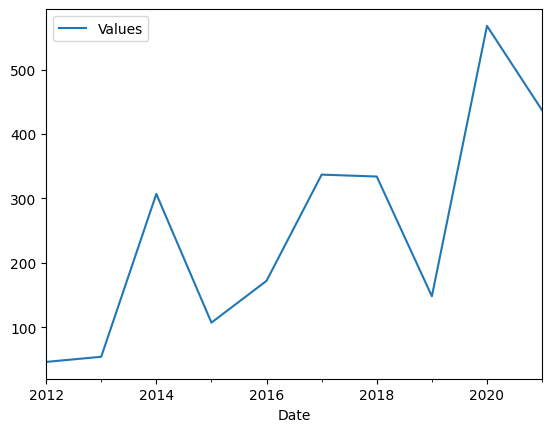

In [218]:
df.plot()

In [219]:


df=pd.read_csv('output.csv')

<Axes: >

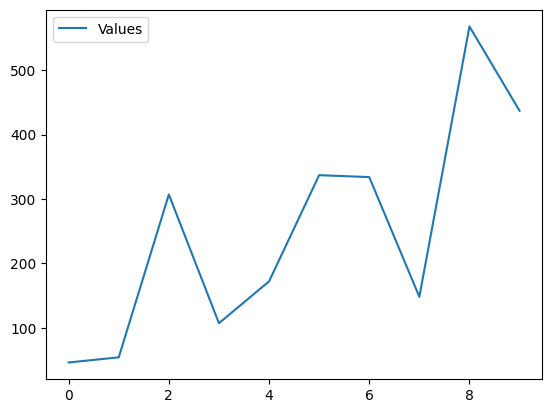

In [220]:
df.plot()

In [221]:
train_size = int(len(df)*0.7)

train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]

In [223]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)
rmse = []
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

In [224]:
list(train.columns)

['Values']

In [225]:
len(train), len(test)

(9, 1)

In [226]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []

    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])

    return np.array(xs), np.array(ys)

In [227]:
xtrain, ytrain = create_dataset(train, train.Values,1)
xtest, ytest = create_dataset(test, test.Values,1)

In [228]:
ytrain

array([ 54, 307, 107, 172, 337, 334, 148, 568])

In [229]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler_y = StandardScaler()

# Reshape y_train to a 2D array and then fit and transform it
ytrain = ytrain.reshape(-1, 1)
ytrain = scaler_y.fit_transform(ytrain)

# Now, y_train_scaled contains the standardized values of y_train


In [230]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True))  # Return sequences for subsequent LSTM layers
model.add(LSTM(50, activation='relu', return_sequences=True))  # Add more LSTM layers
model.add(LSTM(50, activation='relu'))  # Add more LSTM layers
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")


In [231]:
model.fit(xtrain, ytrain,
         epochs=200,
         batch_size=1,
         verbose=1,
         shuffle=False
         )

Epoch 1/200
8/8 [==============================] - 4s 5ms/step - loss: 1.5659
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.9913
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 0.9841
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.9685
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.9435
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.9163
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 0.9041
Epoch 8/200
8/8 [==============================] - 0s 8ms/step - loss: 0.8715
Epoch 9/200
8/8 [==============================] - 0s 5ms/step - loss: 0.8729
Epoch 10/200
8/8 [==============================] - 0s 7ms/step - loss: 0.8257
Epoch 11/200
8/8 [==============================] - 0s 6ms/step - loss: 0.8551
Epoch 12/200
8/8 [==============================] - 0s 5ms/step - loss: 0.7879
Epoch 13/200
8/8 [==============================] - 0s 6ms/st

In [232]:
ypred = model.predict(xtrain)

1/1 [==============================] - 0s 450ms/step


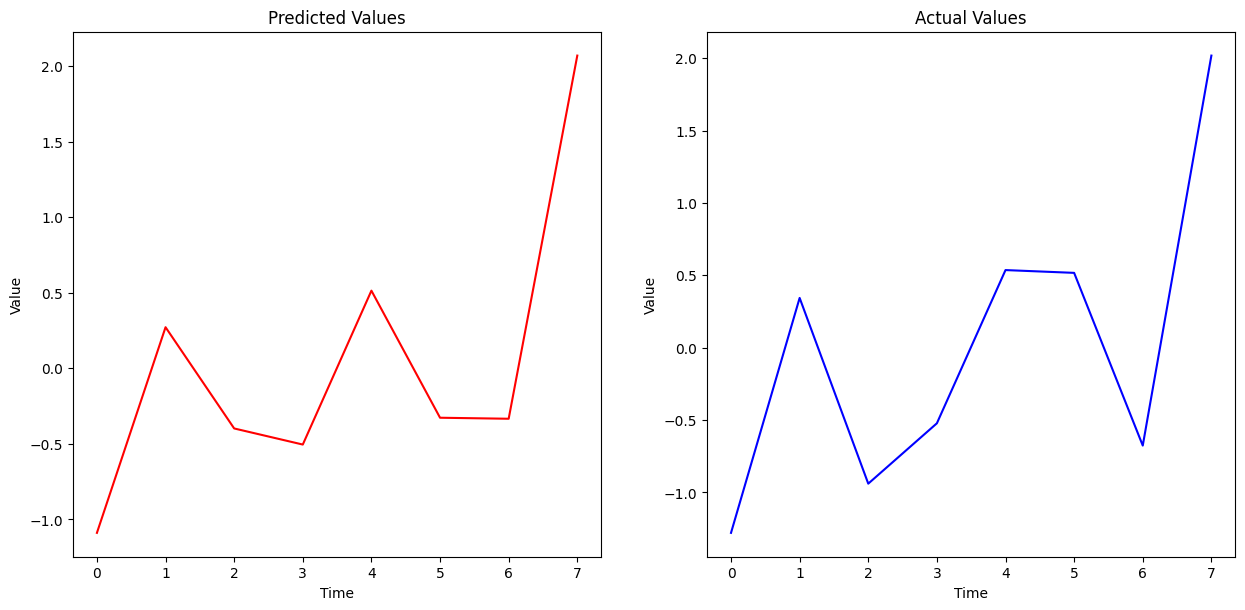

In [233]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()


In [234]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ypred = scaler_y.inverse_transform(ypred)


In [235]:
# Reshape y_train to its original form
ypred = ypred.reshape(-1)


In [236]:
# Inverse transform the standardized y_train_scaled to obtain the original values
ytrain = scaler_y.inverse_transform(ytrain)


In [237]:
# Reshape y_train to its original form
ytrain = ytrain.reshape(-1)


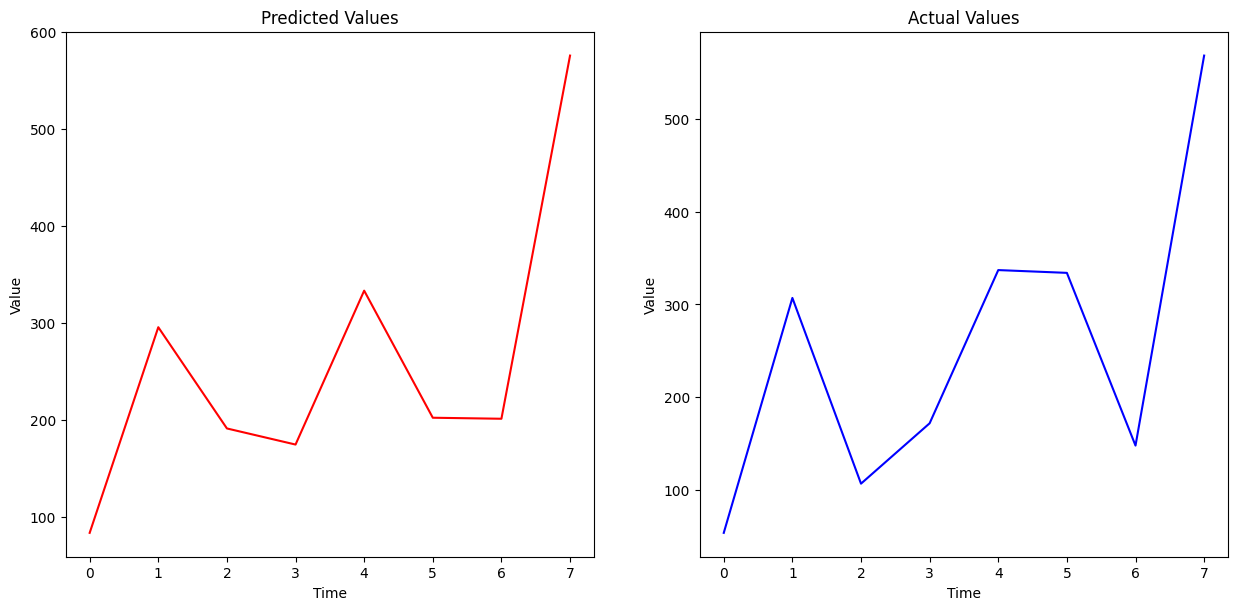

In [238]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(ypred, 'r', label="Predictions")
ax2.plot(ytrain, 'b', label="Actual")

ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.set_title("Predicted Values")

ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.set_title("Actual Values")

plt.show()
